Imports

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, validation_curve, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error, make_scorer, recall_score, precision_score

import joblib


# %load_ext autoreload
#%autoreload 2


# import pandas as pd
# import numpy as np

# import matplotlib.pyplot as plt
# import seaborn as sns
# import missingno as msno

# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler


# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import learning_curve

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# from sklearn.linear_model import LogisticRegression

# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import recall_score

# import joblib


# %load_ext autoreload


#%autoreload 2

In [5]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

1. Data Exploration / Data Cleaning


Explication des données

* id : identifiant unique.  
* gender : genre du patient.  
* age : âge du patient.  
* hypertension : 0 si le patient n'a pas d'hypertension, 1 si le patient a de
l'hypertension.
* heart_disease : 0 si le patient n'a pas de maladie cardiaque, 1 si le
patient a une maladie cardiaque.
* ever_married : si le patient a déjà été marié ou pas.
* work_type : type de travail du patient.
* Residence_type : type de résidence du patient "Rural" ou "Urbain" (=1).
* avg_glucose_level : taux moyen de glucose dans le sang.
* bmi : indice de masse corporelle.
* smoking_status : "a déjà fumé", "n'a jamais fumé", "fumé" ou "Inconnu ".
* stroke : 1 si le patient a eu un accident vasculaire cérébral ou 0 s'il n'en
a pas eu.

In [6]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [7]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]


    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)



    # from Sacia
    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    clean_df = clean_df[clean_df.bmi <= 60]


clean_df.shape

(3531, 12)

In [9]:
clean_df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,31112,0,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1


In [10]:
clean_df.stroke.value_counts(normalize=True)

stroke
0    0.930048
1    0.069952
Name: proportion, dtype: float64

In [11]:
df.smoking_status

0       formerly smoked
1          never smoked
2          never smoked
3                smokes
4          never smoked
             ...       
5105       never smoked
5106       never smoked
5107       never smoked
5108    formerly smoked
5109            Unknown
Name: smoking_status, Length: 5110, dtype: object

In [12]:
corr_map_df = clean_df.drop(columns='id')
corr_map_df.work_type = corr_map_df['work_type'].astype('category')
corr_map_df.work_type = corr_map_df['work_type'].cat.codes

corr_map_df.smoking_status = corr_map_df['smoking_status'].astype('category')
corr_map_df.smoking_status = corr_map_df['smoking_status'].cat.codes


corr_map_df.drop(columns=['ever_married', 'Residence_type', 'avg_glucose_level', 'gender',\
                          'work_type', 'hypertension', 'heart_disease'], inplace=True)

# hsv terrain jet rainbow tab10 Pastel1 Set3 RdBu viridis inferno plasma cividis magma

<Axes: >

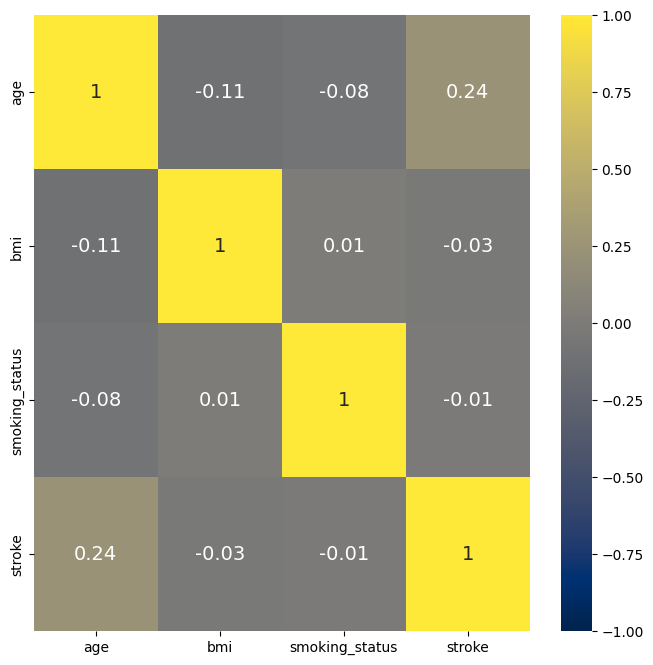

In [13]:
plt.figure(figsize = (8,8))
sns.heatmap(round(corr_map_df.corr(),2), cmap = "cividis", annot = True, annot_kws = {"size":14}, vmin =-1, vmax = 1)

<Axes: >

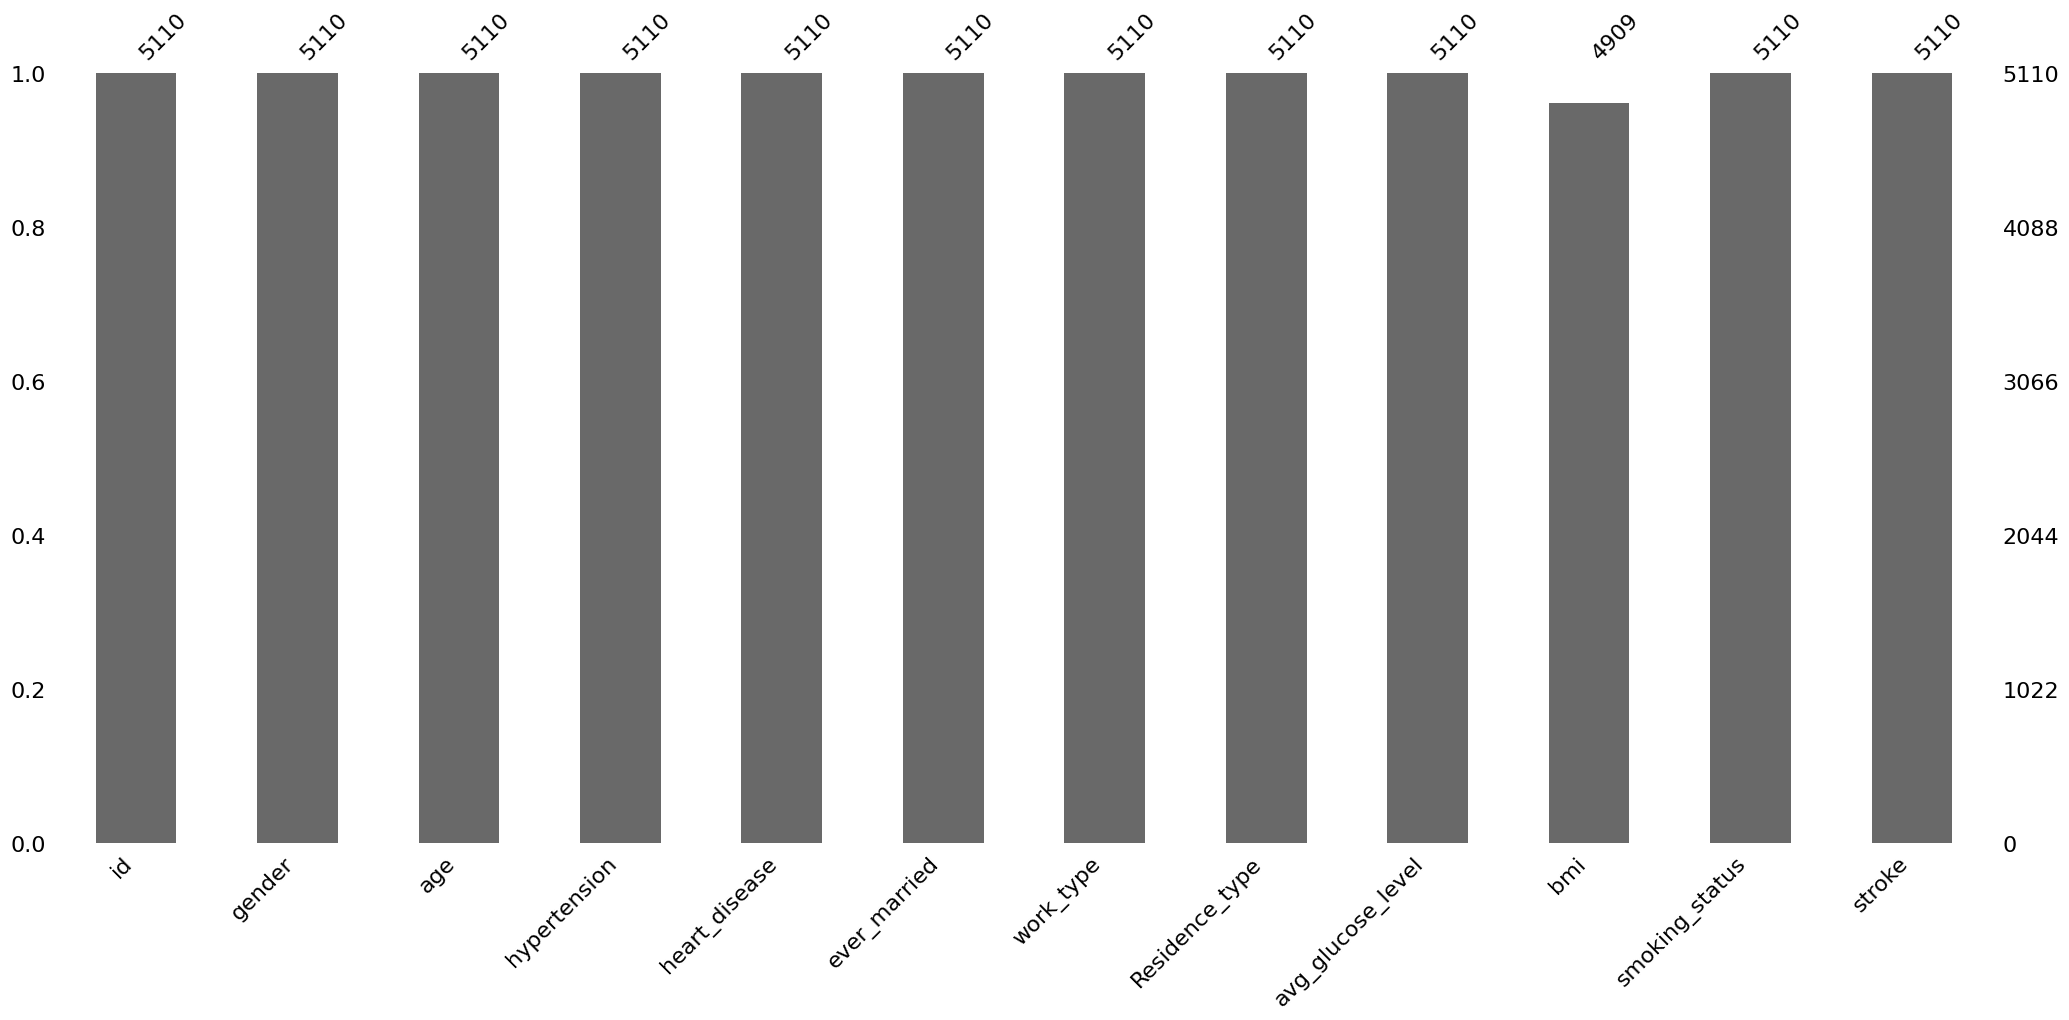

In [14]:
msno.bar(df)

La colonne **bmi** contient 201 valeurs manquantes.  
Avant de choisir une méthode d'imputation, je(Sarah) décide d'observer l'ensemble de mes variables. Cela me permettra de déterminer la méthode optimale d'imputation.

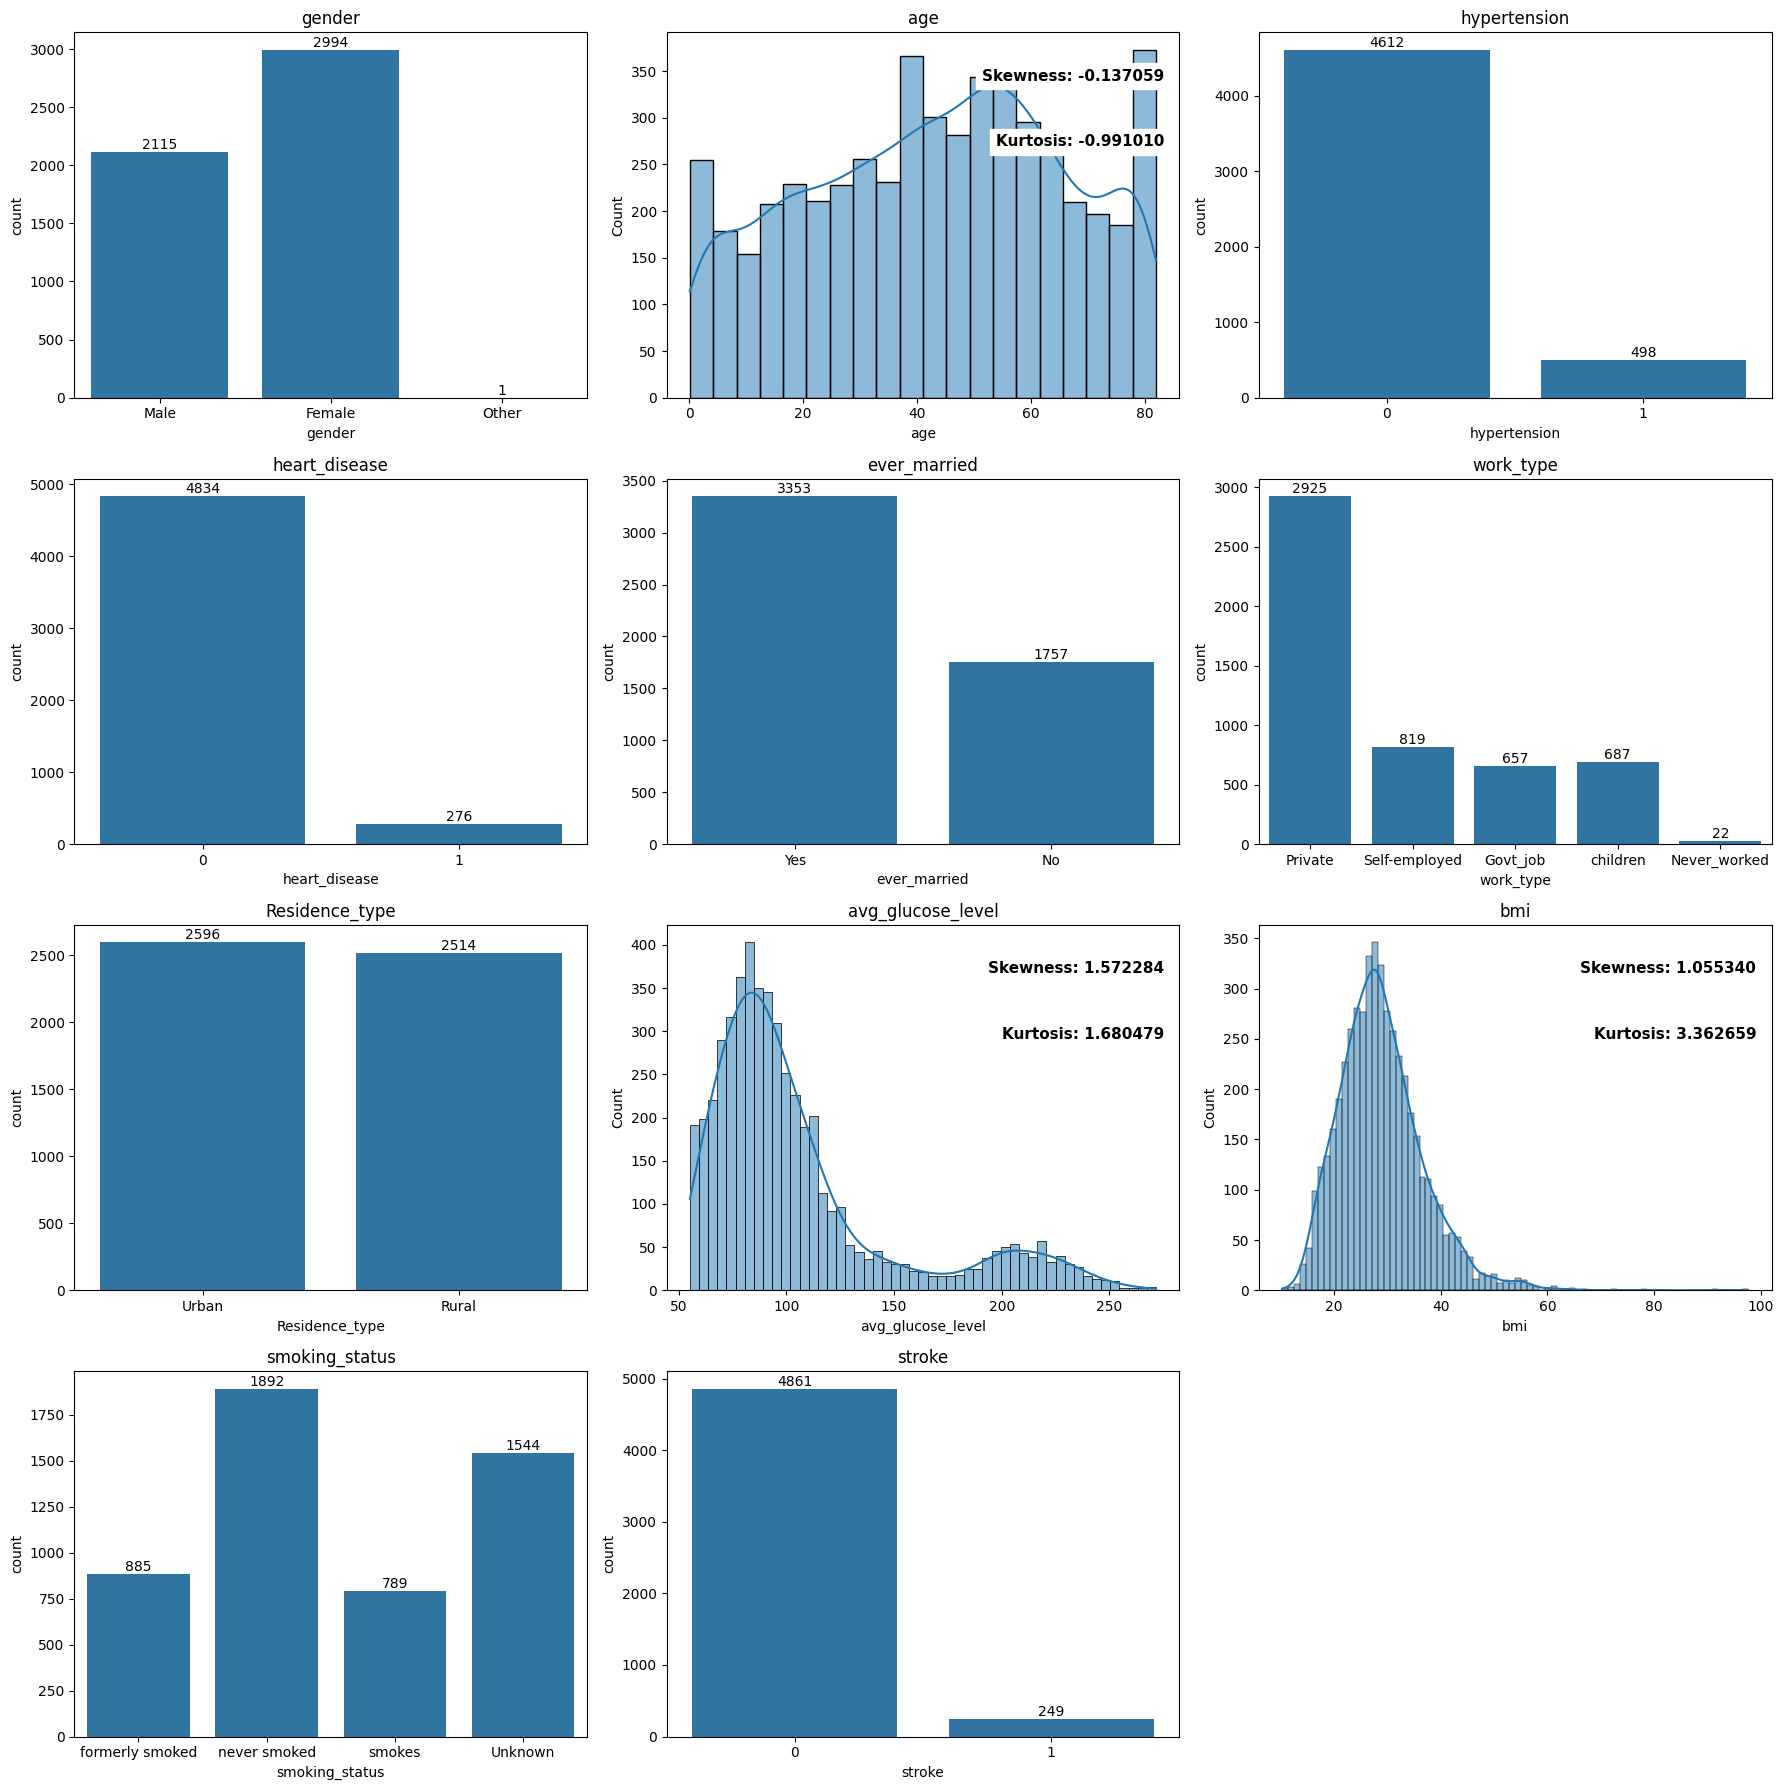

In [15]:
# Sélection des colonnes à visualiser
columns = df.columns[1:]

# Création de sous-plots avec 3 lignes et 3 colonnes
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))

# Boucle pour créer des graphiques
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df[column].dtype == 'object' or df[column].dtype=='int64':
        # Pour les variables catégorielles
        sns.countplot(x=column, data=df, ax=axes[row, col])
        axes[row, col].bar_label(axes[row, col].containers[0])
        axes[row, col].set_title(f'{column}')
    else:
        # Pour les variables continues
        sns.histplot(x=column, data=df, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')
        # Ajout des informations de skewness et kurtosis
        skewness = df[column].skew()
        kurt = df[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')

# Ajustement de l'espacement entre les sous-plots
fig.delaxes(axes[3,2])
plt.tight_layout()
plt.show()


Avant de commencer l'analyse des différentes variables, on remarque que la colonne stroke (dite target) est déséquilibrée.

On va s'intéresser dans un premier temps aux patients qui n'ont jamais eu d'AVC

In [16]:
df_0= df.loc[df['stroke']==0,:];
df_1= df.loc[df['stroke']==1,:]

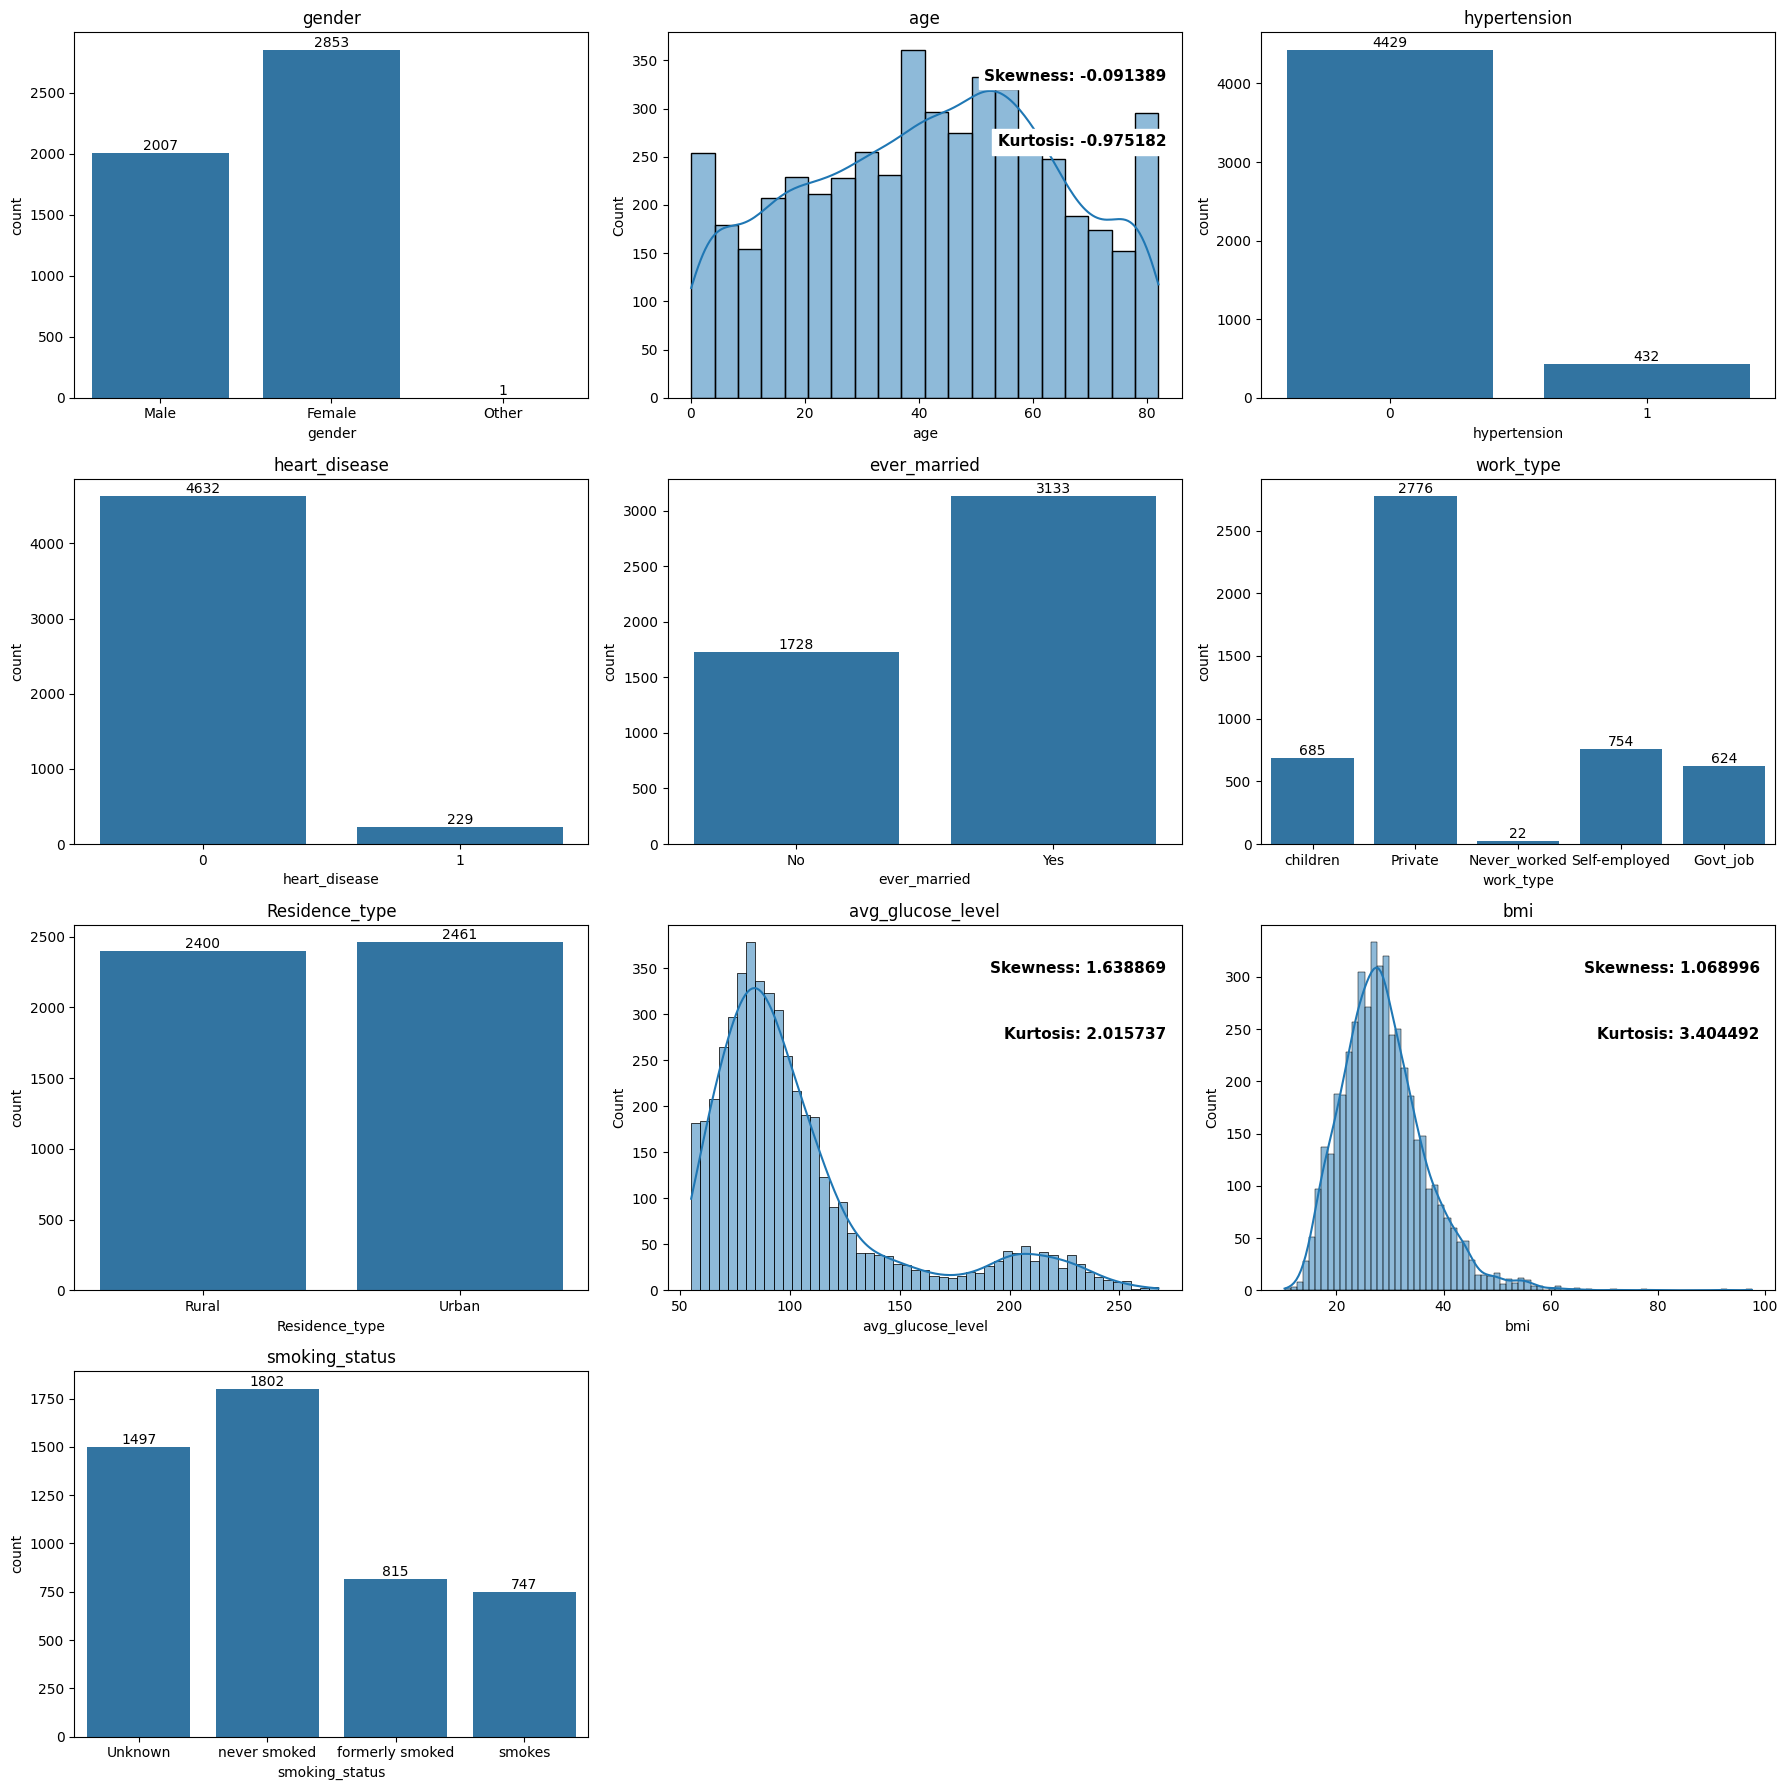

In [17]:
# Sélection des colonnes à visualiser
columns = df_0.columns[1:]

# Création de sous-plots avec 3 lignes et 3 colonnes
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))

# Boucle pour créer des graphiques
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df_0[column].dtype == 'object' or df_0[column].dtype=='int64':
        # Pour les variables catégorielles
        sns.countplot(x=column, data=df_0, ax=axes[row, col])
        axes[row, col].bar_label(axes[row, col].containers[0])
        proportion = df_0[column].value_counts(normalize=True)
        axes[row, col].set_title(f'{column}')
    else:
        # Pour les variables continues
        sns.histplot(x=column, data=df_0, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')
        # Ajout des informations de skewness et kurtosis
        skewness = df_0[column].skew()
        kurt = df_0[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')

# Ajustement de l'espacement entre les sous-plots
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,1])
plt.tight_layout()
plt.show()


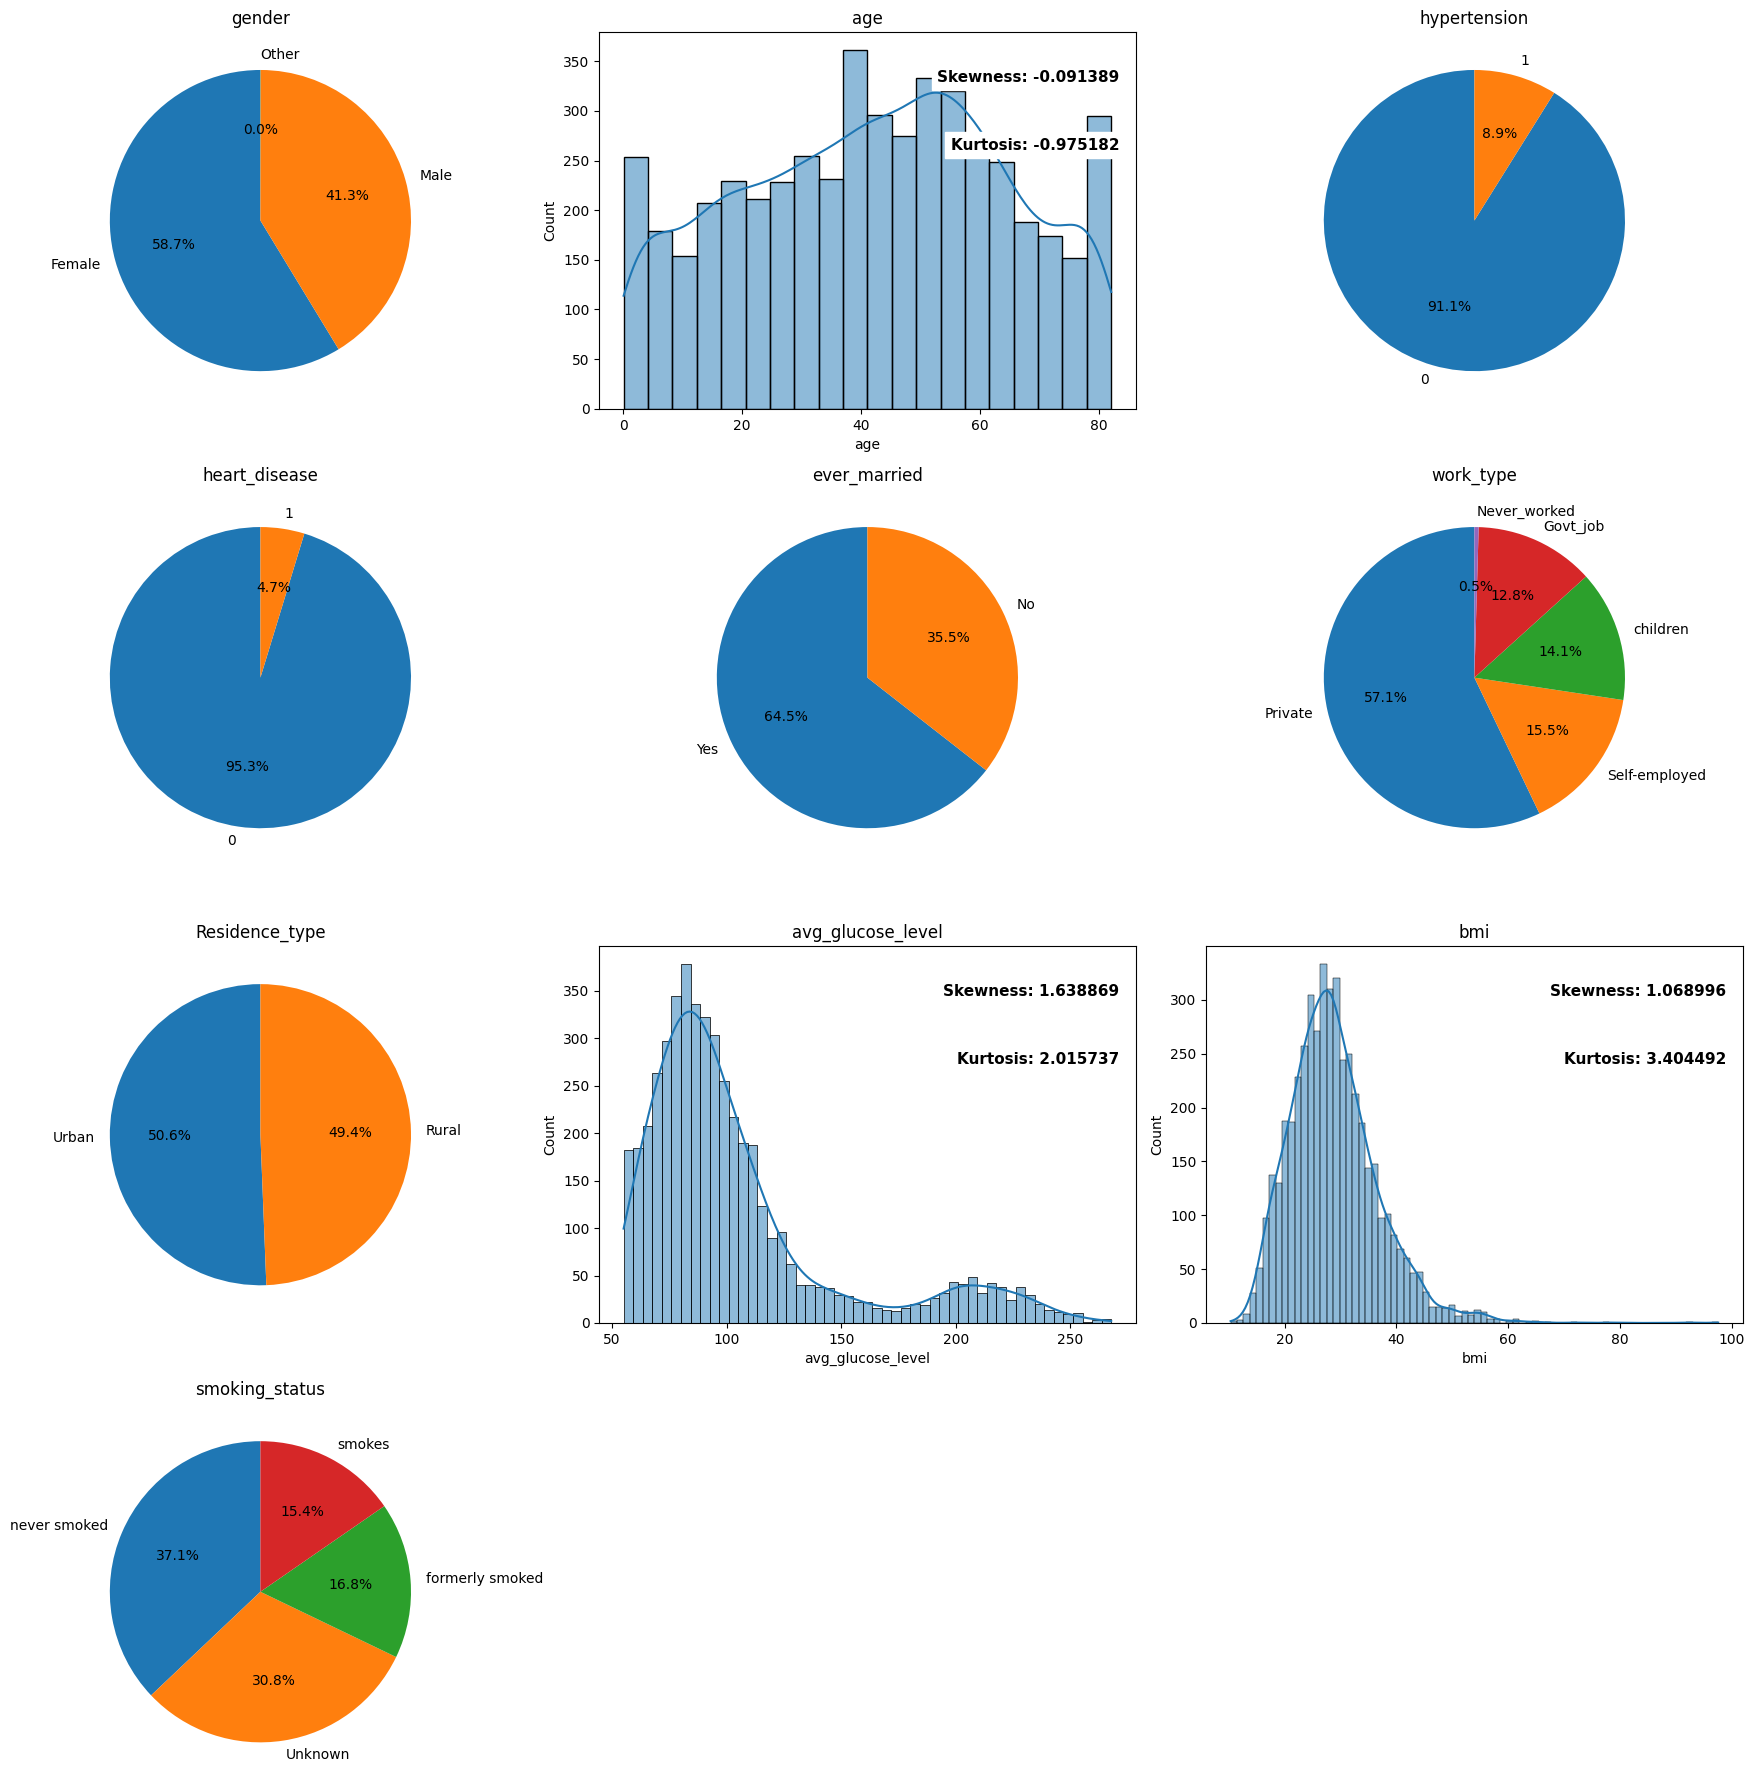

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sélection des colonnes à visualiser
columns = df_0.columns[1:]

# Création de sous-plots avec 4 lignes et 3 colonnes pour accommoder les pie charts
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))

# Boucle pour créer des graphiques
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df_0[column].dtype == 'object' or df_0[column].dtype == 'int64':
        # Pour les variables catégorielles
        proportions = df_0[column].value_counts(normalize=True)
        axes[row, col].pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
        axes[row, col].set_title(f'{column}')
    else:
        # Pour les variables continues
        sns.histplot(x=column, data=df_0, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')
        # Ajout des informations de skewness et kurtosis
        skewness = df_0[column].skew()
        kurt = df_0[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')

# Ajustement de l'espacement entre les sous-plots
fig.delaxes(axes[3, 2])
fig.delaxes(axes[3, 1])
plt.tight_layout()
plt.show()


**Observations des données des personnes classés 0 (pas d'avc):**  
* On compte 60% de femmes pour 40% d'hommes
* La colonne âge indique un score skewness de -0.09 et un score Kurtosis de -0.97, ce qui nous permet de supposer que malgré une légère asymétrie à gauche et un léger aplatissement par rapport à une distribution normale, cette distribution est relativement proche de la normale.
* 92% des personnes de ce groupe ne souffrent pas d'hypertension
* 95% des personnes de ce groupe n'ont pas de maladies cardiaques.
* 64% des personnes ont déjà été marié.  
* 57% des personnes travaillent dans le secteur privé
* Il n'y a pas de classe majoritaire dans la colonne residence type
* Pour la colonne avg glucose level, les valeurs indiquent une distribution qui est à la fois asymétrique vers la droite (skewness positif) et a des pics plus élevés par rapport à une distribution normale (kurtosis positif). 
* La colonne bmi indique une asymétrie à droite (présence d'outliers) et une distribution plus élevée que la normale.

Le coefficient d'asymétrie (Sk, skewness en anglais) évalue le défaut de symétrie d'une distribution:
* Il est **nul pour une distribution symétrique**. 
* Il est **positif pour une distribution étalée à droite**.
* Il est **négatif pour une distribution étalée à gauche.**  

Le coefficient d'aplatissement (K, kurtosis en anglais) évalue la dispersion des valeurs "extrêmes" par référence à la loi normale. 
* Il est **nul pour une distribution normale**
* Il est **négatif pour une distribution moins "aplatie" qu'une distribution normale** 
* Il est **positif sur une distribution plus aplatie qu'une distribution normale.**

On s'intéresse désormais aux patients ayant déjà subis un AVC.

**Observations :**
* La colonne 'gender' comprend 56% de femmes.
* La colonne âge indique une asymétrie à droite avec un skewness à -1.35 et un applatissement plus haut que pour une distribution normale. 
* 73% des personnes de ce groupe n'ont pas d'hypertension
* 81% des personnes de ce groupe n'ont pas de maladies cardiaques
* 88% des personnes ont déjà été mariés
* 59% des personnes travaillent dans le secteur privé
* 55% des personnes vivent en région urbaine
* La colonne avg_glucose est de type bimodale ce qui sous entend qu'il y a 2 sous ensembles au sein de cette catégorie (une concentration entre 50 et 150 et une autre entre 150 et 250)
* Pour la colonne bmi, les valeurs suggèrent une distribution légèrement asymétrique vers la droite, avec une concentration de valeurs plus importante autour de la moyenne et des extrémités plus épaisses que dans une distribution normale. Le kurtosis relativement faible indique que la distribution a des pics qui ne sont pas très élevés par rapport à une distribution normale.
* 36% des personnes de ce groupe n'ont jamais fumé et 28% sont des anciens fumeurs.

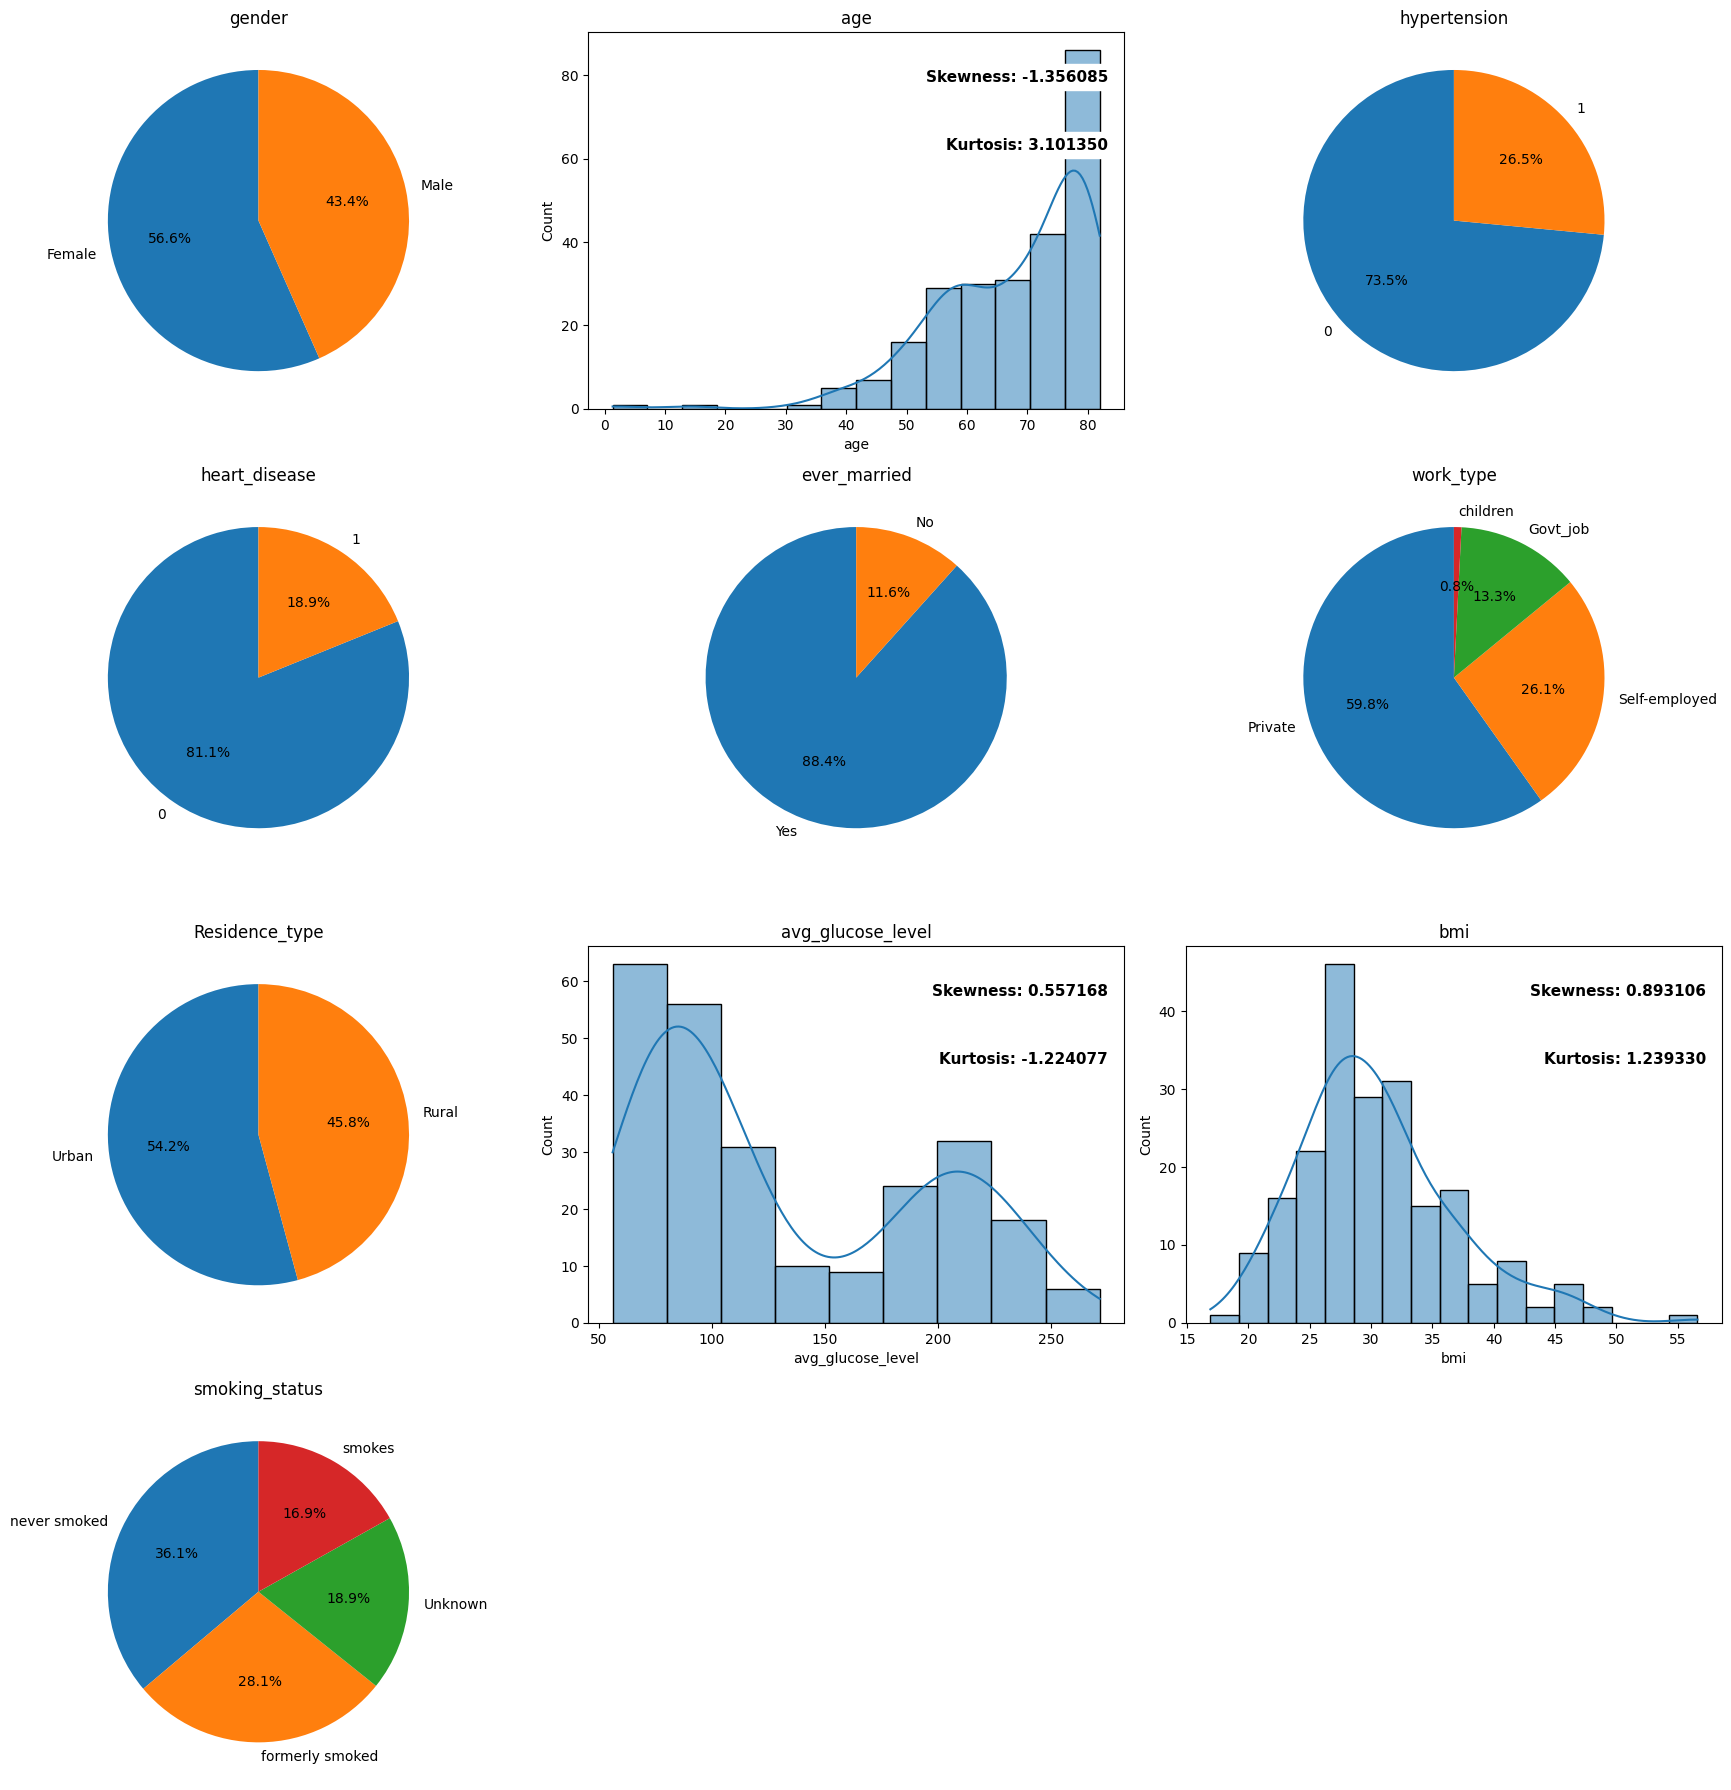

In [19]:
# Sélection des colonnes à visualiser
columns = df_1.columns[1:]

# Création de sous-plots avec 4 lignes et 3 colonnes pour accommoder les pie charts
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))

# Boucle pour créer des graphiques
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df_1[column].dtype == 'object' or df_1[column].dtype == 'int64':
        # Pour les variables catégorielles
        proportions = df_1[column].value_counts(normalize=True)
        axes[row, col].pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
        axes[row, col].set_title(f'{column}')
    else:
        # Pour les variables continues
        sns.histplot(x=column, data=df_1, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column}')
        # Ajout des informations de skewness et kurtosis
        skewness = df_1[column].skew()
        kurt = df_1[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.97, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.97, y=0.70, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')

# Ajustement de l'espacement entre les sous-plots
fig.delaxes(axes[3, 2])
fig.delaxes(axes[3, 1])
plt.tight_layout()
plt.show()


Nos deux groupes présentent des caractéristiques différentes. C'est pour cette raison que l'on a choisi d'utiliser la méthode d'imputation KNN Imputer.

In [20]:
df_nan = df.loc[df['bmi'].isna(),:]
df_nan.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1


In [21]:
df_nan.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,201.000000,201,201.000000,201.000000,201.000000,201,201,201,201.000000,0.0,201,201.000000
unique,NaN,2,NaN,NaN,NaN,2,4,2,NaN,NaN,4,NaN
top,NaN,Male,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,Unknown,NaN
freq,NaN,104,NaN,NaN,NaN,149,114,106,NaN,NaN,61,NaN
mean,23171.109453,NaN,52.049154,0.233831,0.164179,NaN,NaN,NaN,126.724627,NaN,NaN,0.199005
std,20882.483120,NaN,22.276181,0.424323,0.371363,NaN,NaN,NaN,59.240322,NaN,NaN,0.400249
min,67.000000,NaN,0.480000,0.000000,0.000000,NaN,NaN,NaN,57.520000,NaN,NaN,0.000000
25%,4062.000000,NaN,37.000000,0.000000,0.000000,NaN,NaN,NaN,81.430000,NaN,NaN,0.000000
50%,18234.000000,NaN,58.000000,0.000000,0.000000,NaN,NaN,NaN,99.870000,NaN,NaN,0.000000
75%,37937.000000,NaN,71.000000,0.000000,0.000000,NaN,NaN,NaN,191.790000,NaN,NaN,0.000000


In [22]:
df_nan.iloc[:,1:-1].describe(include='all')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
count,201,201.000000,201.000000,201.000000,201,201,201,201.000000,0.0,201
unique,2,NaN,NaN,NaN,2,4,2,NaN,NaN,4
top,Male,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,Unknown
freq,104,NaN,NaN,NaN,149,114,106,NaN,NaN,61
mean,NaN,52.049154,0.233831,0.164179,NaN,NaN,NaN,126.724627,NaN,NaN
std,NaN,22.276181,0.424323,0.371363,NaN,NaN,NaN,59.240322,NaN,NaN
min,NaN,0.480000,0.000000,0.000000,NaN,NaN,NaN,57.520000,NaN,NaN
25%,NaN,37.000000,0.000000,0.000000,NaN,NaN,NaN,81.430000,NaN,NaN
50%,NaN,58.000000,0.000000,0.000000,NaN,NaN,NaN,99.870000,NaN,NaN
75%,NaN,71.000000,0.000000,0.000000,NaN,NaN,NaN,191.790000,NaN,NaN


Pour imputer les valeurs manquantes, **On décide tous ensemble hein Sarah** de commencer par encoder **nos** variables catégorielles et de standardiser **nos** valeurs afin d'appliquer un KNNImputer.

2. Encodage et Normalisation des données

***2.1 Encodage***

**Définition: un encodeur est utilisé pour convertir des variables catégorielles en une variable numérique afin de pouvoir les utiliser sur des modèles de machine learning, qui travaillent généralement avec des données numériques.**. 

Il existe différents type d'encodeurs:  

**LabelEncoder:**  

Il convertit chaque classe unique d'une variable catégorielle en un nombre entier. Utile lorsque l'ordre des catégories n'a pas d'importance.  

**OneHotEncoder:** 

Il crée une colonne binaire distincte pour chaque catégorie unique. Utile lorsque l'ordre des catégories n'a pas d'importance.  

**OrdinalEncoder:**

Il ressemble au LabelEncoder, mais avec la possibilité de spécifier un ordre explicite des catégories.

Pour **mon** jeu de données, **je** décide d'utiliser le One Hot Encodeur.

In [23]:
df_encode = df.copy()
object_cols = df_encode.select_dtypes(include=['object']).columns

# Initialiser l'encodeur One-Hot
encoder = OneHotEncoder()

# Boucle pour encoder chaque colonne 'object'
for col in object_cols:
    # Effectuer l'encodage
    encoded_cols = encoder.fit_transform(df_encode[[col]]).toarray()

    # Créer de nouvelles colonnes avec des noms uniques pour chaque catégorie
    new_cols = [f"{col}_{category}" for category in encoder.get_feature_names_out([col])]

    # Ajouter les nouvelles colonnes au DataFrame
    df_encode[new_cols] = pd.DataFrame(encoded_cols, index=df_encode.index)

    # Supprimer la colonne originale
    df_encode.drop(col, axis=1, inplace=True)

# Afficher le DataFrame après l'encodage
df_encode.head(2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_gender_Female,gender_gender_Male,gender_gender_Other,...,work_type_work_type_Never_worked,work_type_work_type_Private,work_type_work_type_Self-employed,work_type_work_type_children,Residence_type_Residence_type_Rural,Residence_type_Residence_type_Urban,smoking_status_smoking_status_Unknown,smoking_status_smoking_status_formerly smoked,smoking_status_smoking_status_never smoked,smoking_status_smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,51676,61.0,0,0,202.21,NaN,1,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


2.2 Standardisation (normalisation)

Pour pouvoir utiliser le KNN Imputer, je dois aussi mettre à l'échelle mes données.  
Sklearn propose 3 types de standardiseurs :  
* **Standard Scaler** : Il standardise les données en les centrant autour de zéro (moyenne = 0) et en les mettant à l'échelle en fonction de l'écart type.   
* **Min Max Scaler** : Il met à l'échelle les données dans une plage spécifique, généralement entre 0 et 1. Il est utile lorsque les données ont une distribution non normale ou avec des algorithmes sensibles à l'échelle.  
* **Robust Scaler** : Il utilise des statistiques robustes en éliminant les médianes et en échelonnant les données en fonction des quantiles. Cela le rend robuste aux valeurs aberrantes.

In [24]:
column_ibm = df_encode[['bmi']]
other_columns = df_encode.drop(columns=['bmi'])

# Utiliser le KNNImputer pour remplacer les valeurs manquantes dans la colonne "ibm"
knn_imputer = KNNImputer(n_neighbors=2)
column_ibm_imputed = knn_imputer.fit_transform(column_ibm)

# Remplacer la colonne "ibm" dans le DataFrame original
df['bmi'] = column_ibm_imputed

# Appliquer le RobustScaler aux données
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_encode)
# Recréer un DataFrame avec les données mises à l'échelle
df_scaled = pd.DataFrame(df_scaled, columns=df_encode.columns)

# Afficher le DataFrame mis à l'échelle
print(df_scaled)

            id       age  hypertension  heart_disease  avg_glucose_level  \
0    -0.754885  0.611111           0.0            1.0           3.712987   
1     0.399126  0.444444           0.0            0.0           2.994300   
2    -0.157550  0.972222           0.0            1.0           0.380920   
3     0.629386  0.111111           0.0            0.0           2.153481   
4    -0.954691  0.944444           1.0            0.0           2.231917   
...        ...       ...           ...            ...                ...   
5105 -0.506162  0.972222           1.0            0.0          -0.220790   
5106  0.214966  1.000000           0.0            0.0           0.904193   
5107 -0.465854 -0.277778           0.0            0.0          -0.241417   
5108  0.016567  0.166667           0.0            0.0           2.019406   
5109  0.209714 -0.027778           0.0            0.0          -0.179264   

           bmi  stroke  gender_gender_Female  gender_gender_Male  \
0     0.885417     

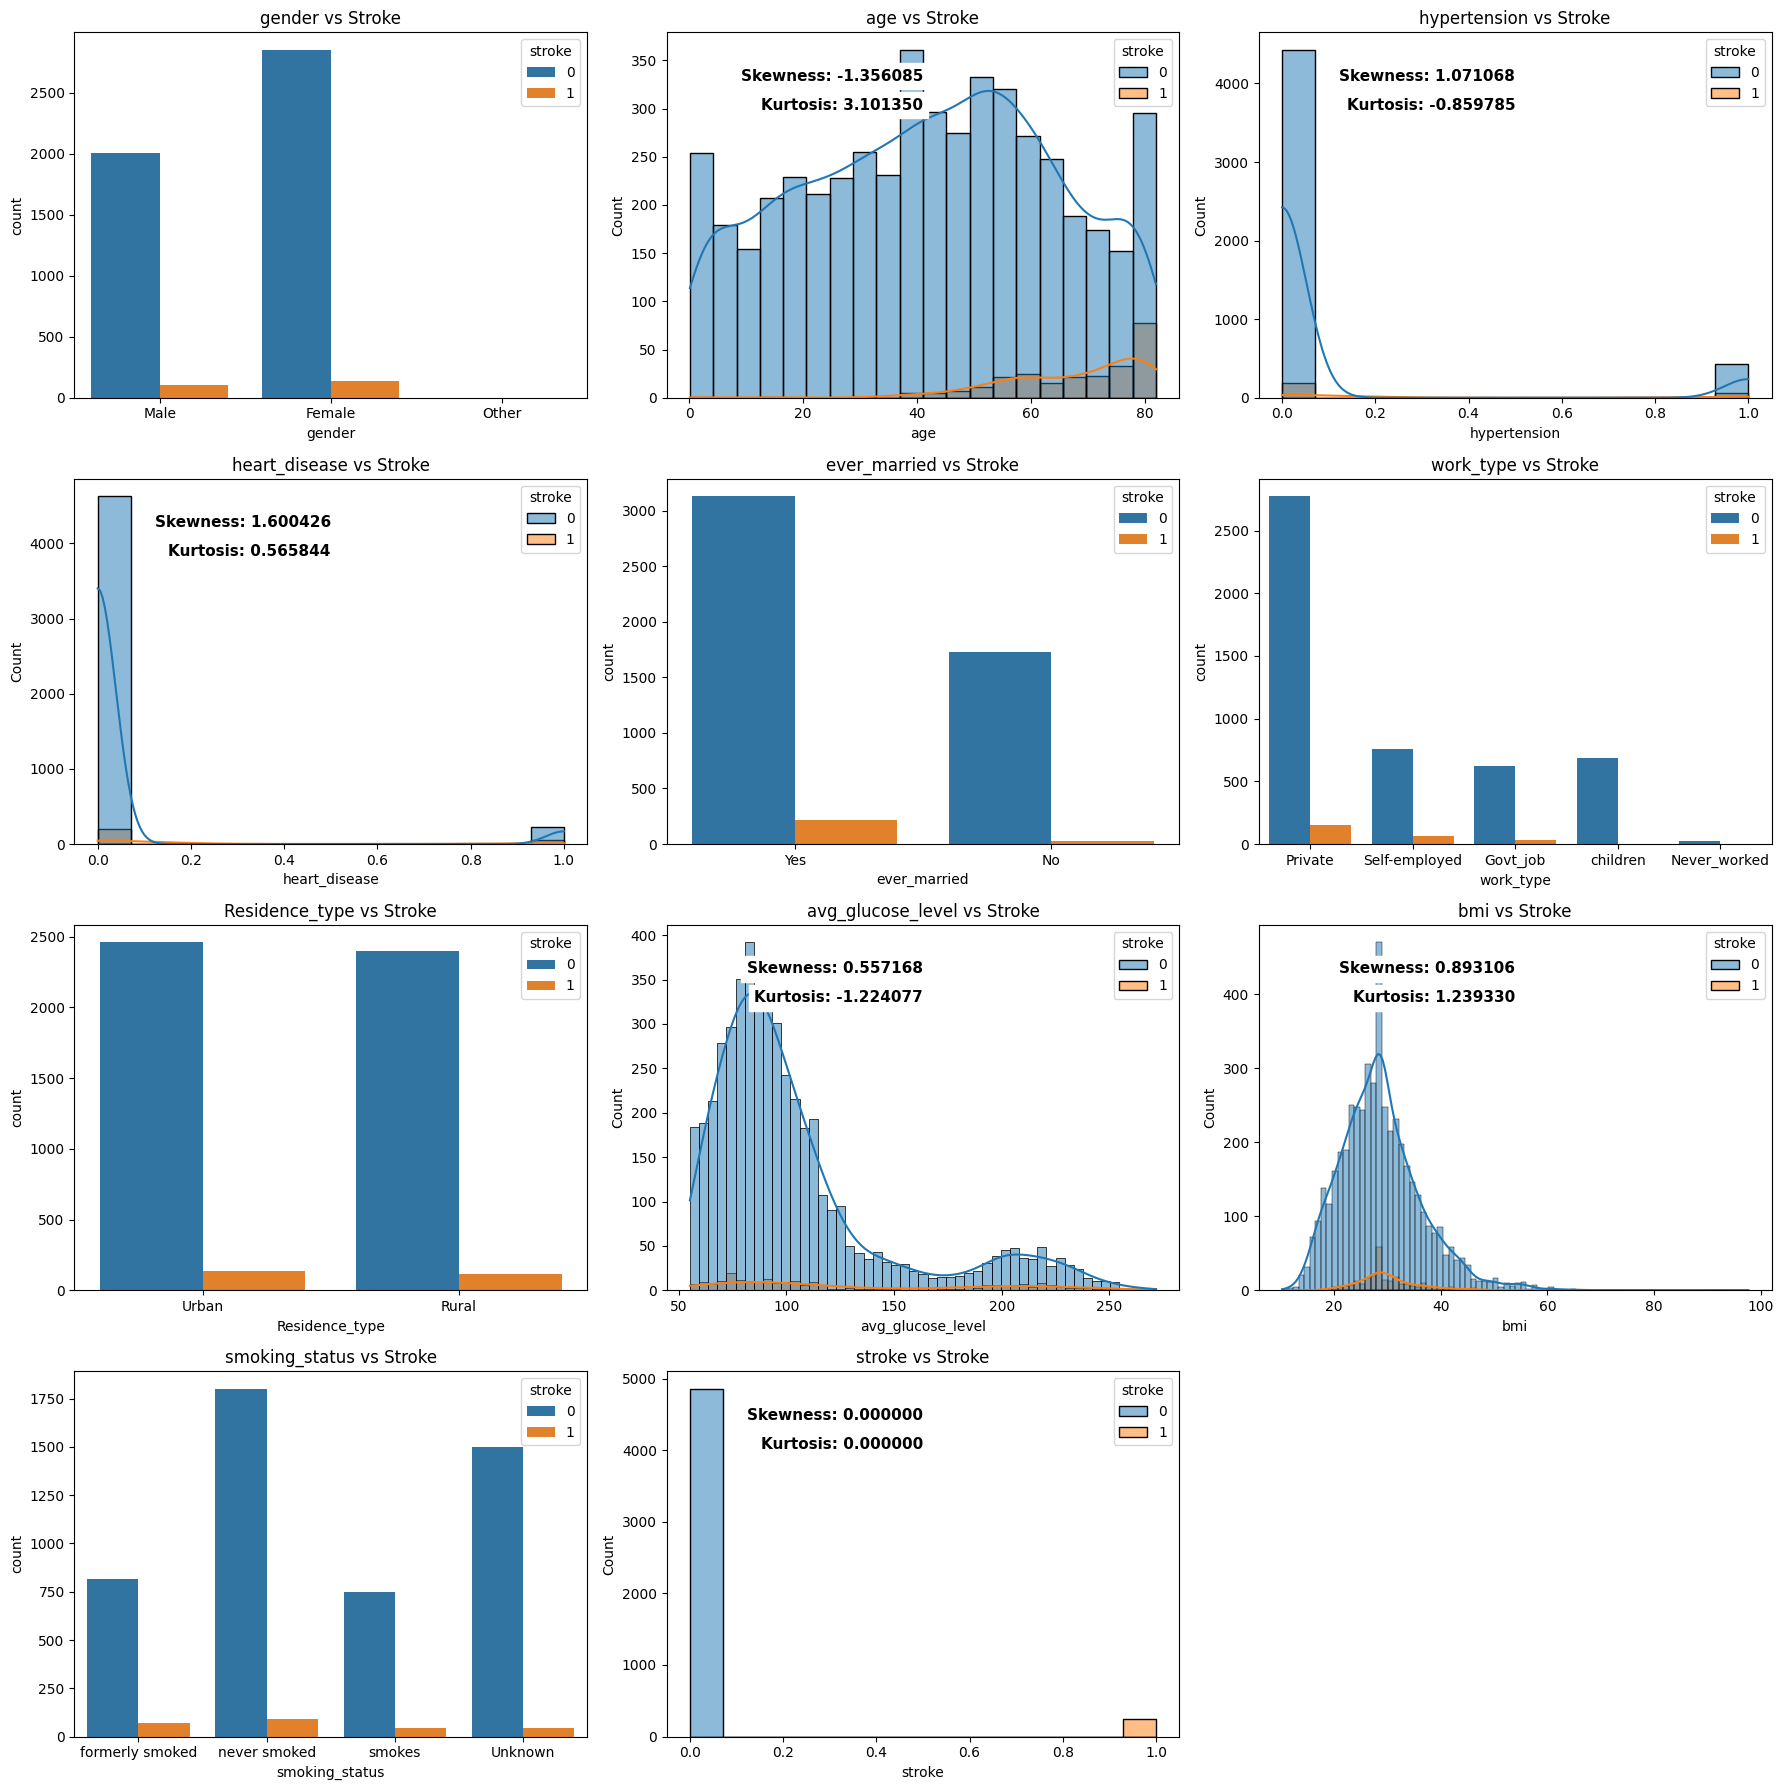

In [25]:
# Sélection des colonnes à visualiser
columns = df.columns[1:]

# Création de sous-plots avec 3 lignes et 3 colonnes
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))

# Boucle pour créer des graphiques
for i, column in enumerate(columns):
    row = i // 3
    col = i % 3

    if df[column].dtype == 'object':
        # Pour les variables catégorielles
        sns.countplot(x=column, hue='stroke', data=df, ax=axes[row, col])
        axes[row, col].set_title(f'{column} vs Stroke')
    else:
        # Pour les variables continues
        sns.histplot(x=column, hue='stroke', data=df, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column} vs Stroke')
        # Ajout des informations de skewness et kurtosis
        skewness = df_1[column].skew()
        kurt = df_1[column].kurt()
        if not pd.isnull(skewness) and not pd.isnull(kurt):
            axes[row, col].text(x=0.5, y=0.90, transform=axes[row, col].transAxes,
                                s="Skewness: %f" % skewness,
                                fontweight='demibold', fontsize=11, verticalalignment='top',
                                horizontalalignment='right', backgroundcolor='white')
            axes[row, col].text(x=0.5, y=0.80, transform=axes[row, col].transAxes,
                                s="Kurtosis: %f" % kurt,
                                fontweight='demibold', fontsize=11, verticalalignment='center',
                                horizontalalignment='right', backgroundcolor='white')

# Ajustement de l'espacement entre les sous-plots
fig.delaxes(axes[3,2])
plt.tight_layout()
plt.show()


In [26]:
df_scaled.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_gender_Female,gender_gender_Male,gender_gender_Other,...,work_type_work_type_Never_worked,work_type_work_type_Private,work_type_work_type_Self-employed,work_type_work_type_children,Residence_type_Residence_type_Rural,Residence_type_Residence_type_Urban,smoking_status_smoking_status_Unknown,smoking_status_smoking_status_formerly smoked,smoking_status_smoking_status_never smoked,smoking_status_smoking_status_smokes
0,-0.754885,0.611111,0.0,1.0,3.712987,0.885417,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.399126,0.444444,0.0,0.0,2.994300,NaN,1.0,0.0,0.0,0.0,...,0.0,-1.0,1.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0
2,-0.157550,0.972222,0.0,1.0,0.380920,0.458333,1.0,-1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0
3,0.629386,0.111111,0.0,0.0,2.153481,0.656250,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.954691,0.944444,1.0,0.0,2.231917,-0.427083,1.0,0.0,0.0,0.0,...,0.0,-1.0,1.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0


**3. Extraire les informations importantes**


A partir de 55 ans, chaque décénie double le risque d'AVC.



D'après :
Rothwell PM, Coull AJ, Silver LE, et al. Population-based study of event-rate, incidence, case fatality, and mortality for all acute vascular events in all arterial territories (Oxford vascular study). Lancet 2005; 366 : 1773–83.

**4. La classification supervisée**

La classification supervisée est un type d'apprentissage supervisé où l'algorithme est entrainé sur un dataset dit labélisé, la caractéristique(feature) que l'on va chercher à prédire doit déjà exister dans le jeu de données pour l'appliquer.

C'est donc un processus fondamentalement différent de l'apprentissage non supervisé où la caractéristique que l'on souhaite prédire n'existe pas dans le jeu de données.

Il existe également d'autres formes d'apprentissage en machine learning comme l'apprentissage semi-supervisé qui mêle les deux précédentes approches et l'apprentissage par renforcement qui se base sur un système de récompenses et pénalités accordées au model.

**4.1 La régression logistique**

La régression logistique est un modèle statistique permettant d’étudier les relations entre un ensemble de variables qualitatives Xi et une variable qualitative Y.
Il s’agit d’un modèle linéaire généralisé utilisant une fonction logistique comme fonction de lien. 

**4.2 Random Tree Classifier** 

Random forest signifie « forêt aléatoire », c’est un algorithme qui se base sur l’assemblage d’arbres de décision. Il est assez intuitif à comprendre, rapide à entraîner et il produit des résultats généralisables.

**4.3 Decision Tree Classifier A remplacer IMO**

L'abre de décision en machine learning est un algorithme de classification supervisé dont la structure interne se rapproche de celle d'un arbre où chaque branche représente une décision binaire et chaque noeud qui relie ces branches le résultat de cette décision.

**5. Application des trois models précédents sur une seule feature**

In [34]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
clean_df = df.copy()

if "Other" in clean_df.gender.value_counts():
    clean_df = df[df.gender != 'Other']
    # on va en discuter tkt
    clean_df = clean_df[clean_df.age>30]
    # clean_df = clean_df.dropna(axis=0, subset='bmi')

    # binaires à faire dans la pipeline dans le script bonus
    clean_df.ever_married = clean_df.ever_married.apply(lambda x : 1 if x == "Yes" else 0)
    clean_df.Residence_type = clean_df.Residence_type.apply(lambda x : 1 if x == "Urban" else 0)
    clean_df.gender = clean_df.gender.apply(lambda x : 1 if x == "Female" else 0)
    # clean_df.bmi = clean_df.bmi.apply(lambda x : x if isinstance(x, float) else 0)

    clean_df['bmi'] = clean_df['bmi'].fillna(df['bmi'].median())
    # ideally do this before fillna but it discards nans too
    clean_df = clean_df[clean_df.bmi <= 60]

    class_0_df = clean_df[clean_df['stroke'] == 0]
    class_1_df = clean_df[clean_df['stroke'] == 1]
    undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
    # undersampled_class_0_data = class_0_df.sample(n=len(class_1_df)*2, replace=True, random_state=42)
    clean_df = pd.concat([class_1_df, undersampled_class_0_data, class_1_df]) #class_1_df
    clean_df = clean_df.sample(frac=1, random_state=42)
clean_df.stroke.value_counts()


stroke
1    494
0    494
Name: count, dtype: int64

**5.1 La régression logistique**

In [33]:
select_features = ['age']

X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
recall_list = []
precision_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # random_state=np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('minmax', MinMaxScaler(), select_features), # ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LogisticRegression(penalty='l2', max_iter=100000, class_weight='balanced'))  # Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    pipeline.fit(X_train, y_train)

    recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
    precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean()) # precision , error_score=0, n_jobs=-1

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")
print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1 - ['age']
# Mean Precision: 0.69770
min/max Precision result[0.619437019969278, 0.7679536589171478]
# Mean Recall: 0.69108
min/max recall result[0.6160919540229884, 0.7468965517241379]


**5.2 Random Tree Classifier** 

In [44]:
select_features = ['age']

X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
recall_list = []
precision_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # random_state=np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('minmax', MinMaxScaler(), select_features), # ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random_forest_classifier', RandomForestClassifier(max_depth=2, random_state=0))# Linear Regression model class_weight='balanced' , n_jobs=4
    ])
    pipeline.fit(X_train, y_train)

    recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
    precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean()) # precision , error_score=0, n_jobs=-1

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")



print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1 - ['age']
# Mean Precision: 0.69628
min/max Precision result[0.6351112026248142, 0.7484615645393677]
# Mean Recall: 0.69132
min/max recall result[0.5809116809116809, 0.7843678160919542]


**5.3 Decision Tree Classifier A remplacer IMO**

In [46]:
select_features = ['age']

X = clean_df[select_features]
y = clean_df['stroke']  # Target

recall = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
recall_list = []
precision_list = []

# allow more accurate model's performance estimation with more training reps and
# different data splits on a small amount of data, needs to be 1 for prediction tasks.
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # random_state=np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        ('minmax', MinMaxScaler(), select_features), # ('robust_scaler', RobustScaler(), to_robust), # RobustScaler/StandardScaler ('minmax', MinMaxScaler(), to_min_max),
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('decision_tree', DecisionTreeClassifier(max_depth=2, random_state=0, class_weight='balanced'))
    ])
    pipeline.fit(X_train, y_train)

    recall_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=recall).mean())
    precision_list.append(cross_val_score(pipeline, X_test, y_test, cv=5, scoring=precision_scorer, verbose=0).mean()) # precision , error_score=0, n_jobs=-1

print(f"# Used features count : {len(select_features) } - {select_features}") #/len(df.columns)
print(f"# Mean Precision: {np.mean(precision_list):.5f}")
print(f"min/max Precision result{[min(precision_list), max(precision_list)]}")
print(f"# Mean Recall: {np.mean(recall_list):.5f}")



print(f"min/max recall result{[min(recall_list), max(recall_list)]}")

# Used features count : 1 - ['age']
# Mean Precision: 0.69399
min/max Precision result[0.6089646503119741, 0.8036206110351118]
# Mean Recall: 0.66771
min/max recall result[0.5179435483870968, 0.7965608465608465]


**6. Evaluation des résultats des models et explication du choix de la métrique utilisée**

Sur une seule métrique, les trois models proposent des résultats très similaires et au dessus de la baseline à 0.5


**Manque explication du choix de la métrique utilisé**

**7. Etes-vous satisfait des résultats obtenus ?**

Nous ne sommes pas satisfaits des résultats obtenus par nos premiers models dans la mesure où si le score de précision est presque acceptable, on ne peut pas se permettre d'avoir un score recall aussi faible dans un objectif de prévision de risques médicaux pouvant entraîner la mort.

**7.5 Ajout de nouvelles features aux model, les justifier.**

**8. Comparaison avec les résultats précédents.**

**8.5 Conclusion sur la modélisation la plus efficace pour la prévention des attaques cérébrales.**